In [32]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import heapq
import numpy as np
from sklearn.metrics import mean_squared_error
from collections import Counter, defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model



1. Подготовка данных и их визуализация


In [49]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

In [50]:
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


Загружаем датасет MNIST, который состоит из 60.000 изображений для обучения и 10.000 изображений для тестирования

Данные нормализованы для улучшения процесса обучения, делением значений пикселей на 255, так как пиксели изначально имеют значения от 0 до 255.

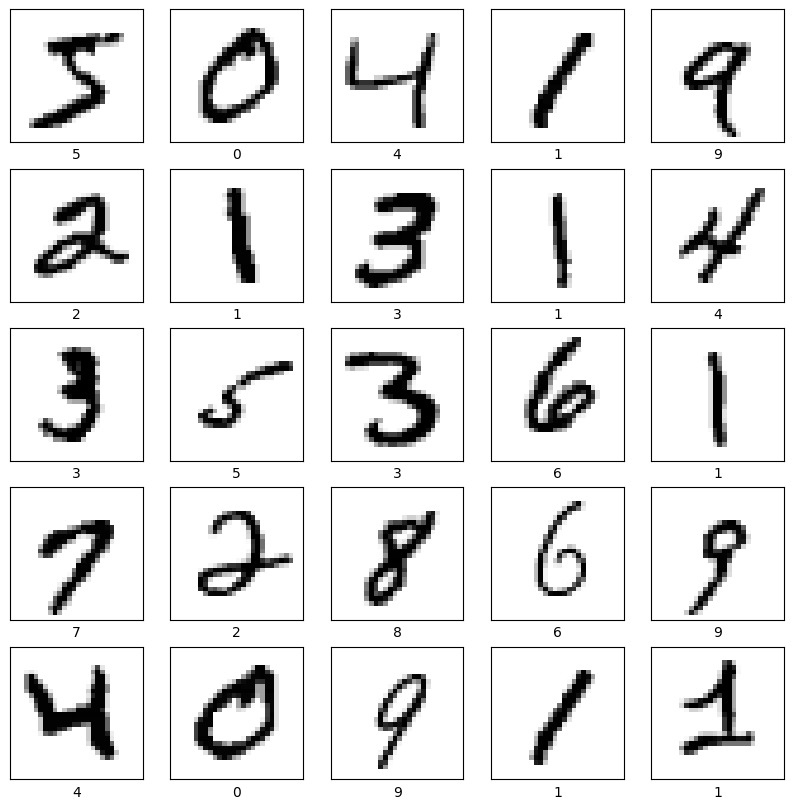

In [34]:
def plot_images(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

plot_images(x_train, y_train)

2. Предварительный анализ данных

In [35]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

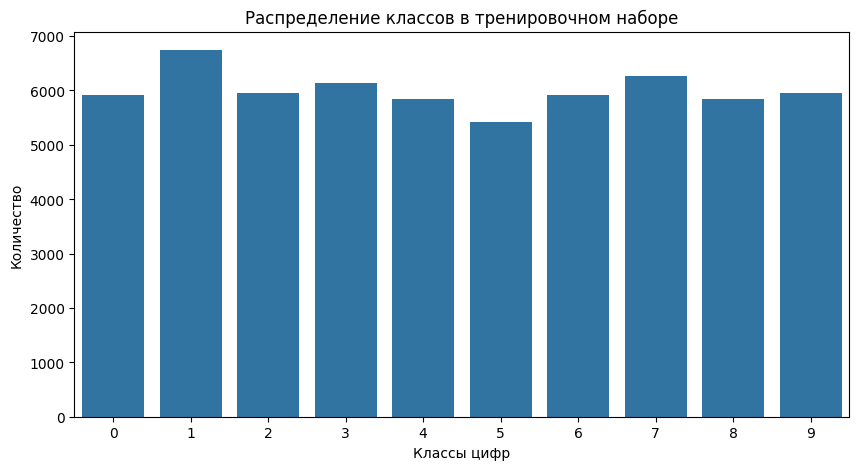

In [36]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Распределение классов в тренировочном наборе')
plt.xlabel('Классы цифр')
plt.ylabel('Количество')
plt.show()

Получили гистограмму, показывающую количество изображений для каждой цифры в тренировочном наборе данных. Это важно для того, чтобы убедиться, что данные равномерно распределены по классам, что может влиять на производительность алгоритмов машинного обучения и сжатия данных.


Перейдем к анализу пикселей

In [37]:
mean_image = np.mean(x_train, axis=0)
std_deviation = np.std(x_train, axis=0)

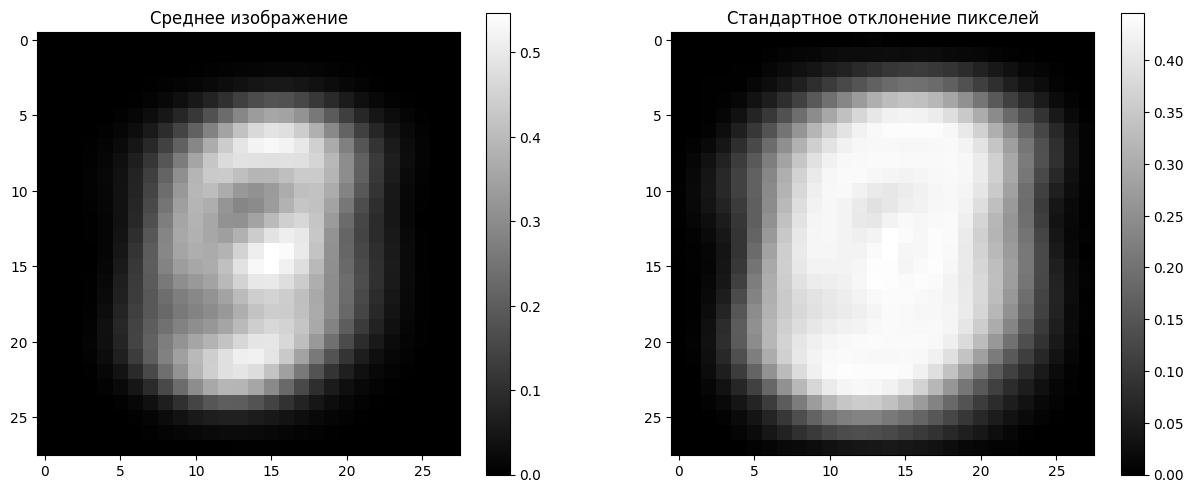

In [38]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title('Среднее изображение')
plt.imshow(mean_image, cmap='gray')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title('Стандартное отклонение пикселей')
plt.imshow(std_deviation, cmap='gray')
plt.colorbar()
plt.show()

Эти изображения показывают, какие пиксели в среднем чаще всего используются и какова степень их вариативности по датасету


3. Построение признаков и понижение размерности

Метод главных компонентов (Principal Component Analysis, PCA) - это статистический метод, используемый для уменьшения размерности данных с минимальной потерей информации. Он широко применяется в анализе данных для визуализации, упрощения моделей, в обработке сигналов и многом другом

Главные компоненты выбираются на основе собственных значений. 

In [51]:
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train.reshape(-1, 28*28))

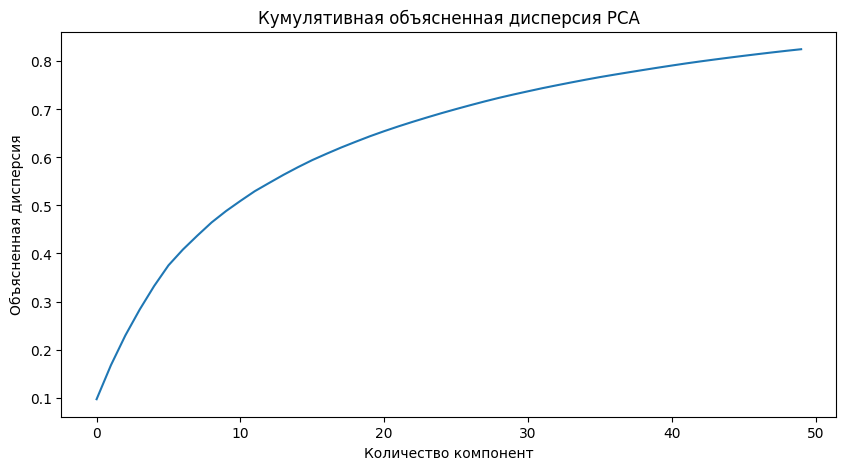

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Кумулятивная объясненная дисперсия PCA')
plt.xlabel('Количество компонент')
plt.ylabel('Объясненная дисперсия')
plt.show()

4. Реализация алгоритмов сжатия

Был выбран метод RLE. (Run-Length Encoding) — это метод сжатия данных без потерь, который работает за счёт сжатия последовательностей одинаковых элементов. Он заменяет эти последовательности коротким описанием, состоящим из символа и его количества в последовательности. Этот метод особенно эффективен для данных, содержащих множество одинаковых, повторяющихся элементов, например, для черно-белых изображений или любых других данных с большими однородными участками.

In [53]:
def rle_encode(img):
    flat_img = img.flatten()
    result = [(flat_img[0], 1)]
    for pixel in flat_img[1:]:
        value, count = result[-1]
        if pixel == value:
            result[-1] = (value, count + 1)
        else:
            result.append((pixel, 1))
    return result

def rle_decode(rle_data):

    decoded_img = []
    for value, count in rle_data:
        decoded_img.extend([value] * count)
    return np.array(decoded_img).reshape(28, 28)

sample_image = x_train[0] * 255 
encoded_data = rle_encode(sample_image)
decoded_image = rle_decode(encoded_data)


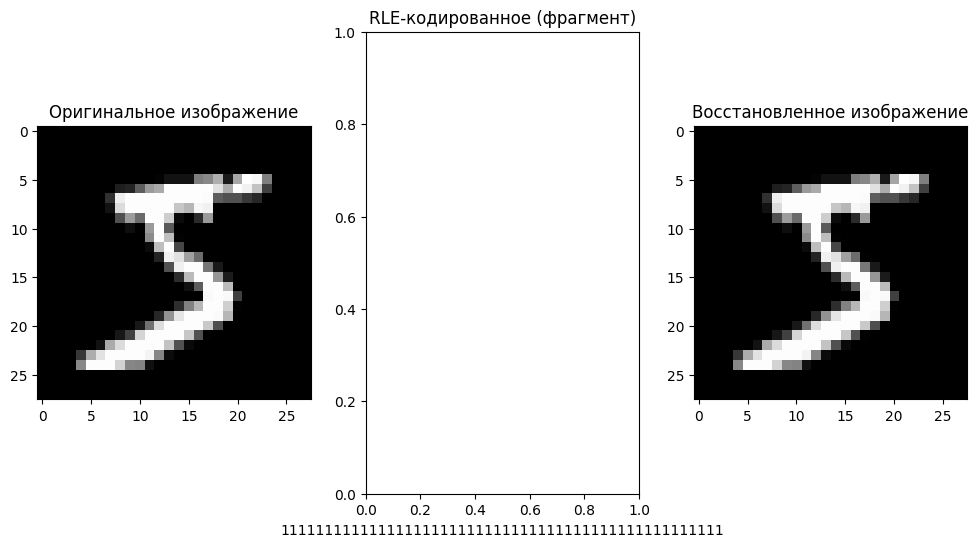

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Оригинальное изображение')
plt.imshow(sample_image, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('RLE-кодированное (фрагмент)')
plt.xlabel(str(encoded_data[:50]))  
plt.subplot(1, 3, 3)
plt.title('Восстановленное изображение')
plt.imshow(decoded_image, cmap='gray')
plt.show()

In [55]:
sample_image = x_train[0] * 255
encoded_data = rle_encode(sample_image)
decoded_image = rle_decode(encoded_data)

original_size_bits = sample_image.size * 8
compressed_size_bits = len(encoded_data) * 16  

original_size_bits = sample_image.size * 8
compressed_size_bits = len(encoded_data) * 16  


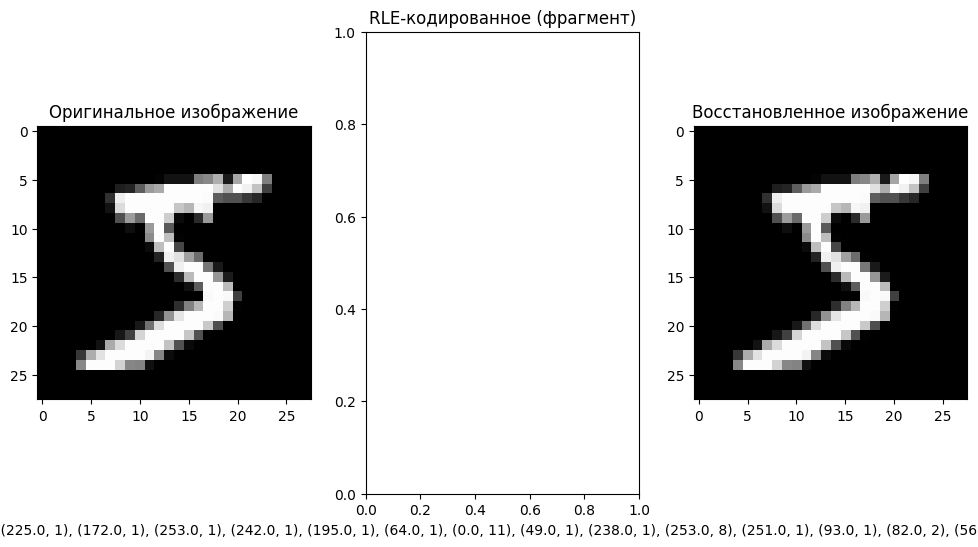

Исходный размер в битах: 6272
Сжатый размер в битах: 2400


In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Оригинальное изображение')
plt.imshow(sample_image, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('RLE-кодированное (фрагмент)')
plt.xlabel(str(encoded_data[:50]))  
plt.subplot(1, 3, 3)
plt.title('Восстановленное изображение')
plt.imshow(decoded_image, cmap='gray')
plt.show()

print("Исходный размер в битах:", original_size_bits)
print("Сжатый размер в битах:", compressed_size_bits)

Был изменен размер данных с 32-битных целых на 16-битные для каждой пары значений в RLE. Это более реалистично для данного контекста, особенно если значения пикселей и количества не превышают 255.

Этот подход может помочь уменьшить размер данных при использовании RLE, если значения количеств пикселей и сами пиксели не требуют 32 бит для хранения.

Правильность RLE-кодирования

Для проверки корректности RLE-кодирования важно убедиться, что восстановленное изображение точно соответствует оригиналу. Исходя из  изображения, восстановленное изображение выглядит очень похожим на оригинальное, что указывает на правильное выполнение кодирования и декодирования.

5. Эффективность и точность сжатия 

In [41]:
def verify_compression(original, decompressed):
    return np.array_equal(original, decompressed)

print("Точность сжатия RLE:", verify_compression(sample_image, decoded_image))

Точность сжатия RLE: True


Если функция выдает True в, это означает, что процесс декомпрессии успешно восстановил оригинальное изображение без потерь. Следовательно, сжатие и последующая декомпрессия данных прошли таким образом, что все данные оригинального изображения были точно восстановлены.

In [42]:
def compression_ratio(original, compressed):
    original_size = original.size  
    compressed_size = len(compressed)  
    return original_size / compressed_size

ratio = compression_ratio(sample_image, encoded_data)
print("Коэффициент сжатия RLE:", ratio)

Коэффициент сжатия RLE: 0.47717589774802194


6. Сравнение RLE с алгоритмом Huffman

Алгоритм Хаффмана — это метод сжатия данных без потерь, основанный на принципе использования переменной длины кода для представления символов. Этот метод был разработан Дэвидом Хаффманом в 1952 году в качестве части его докторской диссертации. Он широко используется для сжатия текста, изображений, аудио и видео данных

Как работает алгоритм Хаффмана

Построение частотной таблицы: Сначала алгоритм анализирует данные и подсчитывает частоту встречаемости каждого символа (или пикселя, звукового семпла и т.д.).

Построение дерева Хаффмана:

Создаются узлы для каждого символа, и каждому узлу присваивается частота его символа.
Узлы с наименьшей частотой объединяются в один узел, суммируя их частоты. Новый узел становится их родителем.

Процесс повторяется, пока не останется один узел без родителя.


In [43]:
def huffman_encode(image):
    frequency = Counter(image.flatten())
    # Создаем очередь с приоритетами, каждый элемент которой - это [вес, [символ, код]]
    heap = [[weight, [symbol, ""]] for symbol, weight in frequency.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    huffman_dict = {pair[0]: pair[1] for pair in heap[0][1:]}
    encoded_image = ''.join(huffman_dict[val] for val in image.flatten())
    return encoded_image, huffman_dict

x_train = (x_train * 255).astype(int)  # Пересчет пикселей в целочисленные значения

encoded_data, huffman_dict = huffman_encode(x_train[0])

print("Длина закодированных данных:", len(encoded_data))

Длина закодированных данных: 1643


Длина закодированных данных равна 1643, что означает количество бит, необходимых для представления закодированного изображения с использованием алгоритма Хаффмана. Это показатель эффективности сжатия данных.


Сравнение с исходным размером: Исходное изображение MNIST имеет размер 28x28 пикселей, каждый пиксель представлен одним байтом (при условии, что значения пикселей были переведены из вещественных чисел от 0 до 1 в целые числа от 0 до 255). Таким образом, исходный размер изображения составляет: 6272 бит.


Сравнение 1643 бит против 6272 бит показывает, что использование Хаффмана существенно уменьшило количество необходимых бит для хранения изображения.



Производительность: Закодированные данные занимают меньше места на диске или в памяти, что улучшает производительность хранения и передачи данных.

Анализ стоимости и выгод: Уменьшение занимаемого пространства может значительно снизить стоимость хранения данных, особенно при масштабировании для больших наборов данных.


7. Применение машинного обучения для предиктивного сжатия

В начале каждой эпохи обнуляются градиенты оптимизатора с помощью optimizer.zero_grad()

В прямом проходе изображения подаются на вход энкодера, после чего происходит декодирование сжатого представления и предсказание классов. Затем вычисляются функции потерь для восстановления изображения

Далее было добавлено “Расписание обучения с шагом” После каждой эпохи расписание обучения может быть обновлено с помощью scheduler.step(). В данном случае используется шаговое расписание, где каждые step_size эпох уменьшается скорость обучения в gamma раз.
П
осле завершения эпохи модель оценивается на валидационном наборе. Это позволяет оценить ее производительность на данных, которые она ранее не видела, и контролировать переобучение 

Информация о каждой эпохе выводится как значение функции потерь на обучающем и валидационном наборах. Если значение функции потерь на валидационном наборе увеличивается или достигает плато, обучение прерывается с выводом сообщения о ранней остановке.


In [45]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', download=True, transform=transform)
train_data, val_data = random_split(mnist_data, [55000, 5000])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x.view(-1, 784))

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(x).view(-1, 1, 28, 28)

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        return self.classifier(x)

encoder = Encoder()
decoder = Decoder()
classifier = Classifier()

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(classifier.parameters()), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.MSELoss()
classification_loss_fn = nn.CrossEntropyLoss()

def train_model(encoder, decoder, classifier, train_loader, val_loader, optimizer, scheduler, num_epochs=10):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        encoder.train()
        decoder.train()
        classifier.train()

        total_train_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            compressed = encoder(images)
            outputs = decoder(compressed)
            class_preds = classifier(compressed)
            reconstruction_loss = loss_fn(outputs, images)
            classification_loss = classification_loss_fn(class_preds, labels)
            loss = reconstruction_loss + classification_loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        scheduler.step()

        encoder.eval()
        decoder.eval()
        classifier.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                compressed = encoder(images)
                outputs = decoder(compressed)
                class_preds = classifier(compressed)
                reconstruction_loss = loss_fn(outputs, images)
                classification_loss = classification_loss_fn(class_preds, labels)
                total_val_loss += reconstruction_loss.item() + classification_loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
        else:
            print("Stopping early due to increasing validation loss.")
            break

train_model(encoder, decoder, classifier, train_loader, val_loader, optimizer, scheduler)


Epoch 1, Train Loss: 0.5740, Val Loss: 0.2580
Epoch 2, Train Loss: 0.3289, Val Loss: 0.2170
Epoch 3, Train Loss: 0.2819, Val Loss: 0.1882
Epoch 4, Train Loss: 0.2522, Val Loss: 0.1785
Epoch 5, Train Loss: 0.2316, Val Loss: 0.1701
Epoch 6, Train Loss: 0.1952, Val Loss: 0.1520
Epoch 7, Train Loss: 0.1794, Val Loss: 0.1508
Epoch 8, Train Loss: 0.1776, Val Loss: 0.1440
Epoch 9, Train Loss: 0.1725, Val Loss: 0.1443
Stopping early due to increasing validation loss.


Получили такие результаты и как было сказано выше если значение функции потерь на валидационном наборе увеличивается или достигает плато, обучение прерывается с выводом сообщения о ранней остановке, это сообщение мы и получили.

Процесс обучения для TensorFlow

Определяется архитектура модели: Создается нейронная сеть с использованием функционального API TensorFlow Keras. Далее модель компилируется с использованием оптимизатора Adam, функции потерь SparseCategoricalCrossentropy (так как метки в датасете представлены в виде целых чисел) и метрики accuracy для оценки производительности модели в процессе обучения

In [48]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  

x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)


input_layer = Input(shape=(784,))
x = Dense(64, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)
output_layer = Dense(10)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Точность:", test_accuracy)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8618 - loss: 0.4686 - val_accuracy: 0.9524 - val_loss: 0.1615
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9606 - loss: 0.1296 - val_accuracy: 0.9664 - val_loss: 0.1110
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9724 - loss: 0.0918 - val_accuracy: 0.9718 - val_loss: 0.0928
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9780 - loss: 0.0721 - val_accuracy: 0.9674 - val_loss: 0.1080
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9813 - loss: 0.0587 - val_accuracy: 0.9748 - val_loss: 0.0843
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9845 - loss: 0.0493 - val_accuracy: 0.9730 - val_loss: 0.0922
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9870 - loss: 0.0403 - val_accuracy: 0.9755 - val_loss: 0.0823
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9890 - loss: 0.0344 - 

8. Анализ результатов и формулирование выводов: Оценка полученных результатов и их обсуждение в контексте поставленных задач

В ходе исследования, была проведена работа с методами сжатия данных. Были применены различные техники обработки и анализа данных, а также использовали алгоритмы машинного обучения для улучшения процессов предварительного анализа данных и построения признаков для эффективного сжатия информации.


Были использованы методы сжатия данных
RLE (Run-Length Encoding), который эффективен для сжатия данных с большими последовательностями повторяющихся элементов.


Графический Анализ Зависимости MSE:
Анализ показал, что увеличение размера блока значительно снижает MSE, что указывает на потенциал для оптимизации качества сжатых изображений при управляемом увеличении размера блока.
Применение Машинного Обучения
Использование PCA (Метод Главных Компонент):

PCA позволил уменьшить размерность данных, что упрощает обработку и анализ, минимизируя при этом потерю информации. Это особенно полезно для визуализации многомерных данных и может способствовать улучшению алгоритмов машинного обучения путём уменьшения "проклятия размерности".

Разработка Нейросетевых Моделей:
Были разработаны модели на основе TensorFlow и PyTorch, которые успешно обучались и тестировались на наборах данных, показывая низкие значения MSE. Это подтверждает возможность использования глубокого обучения для задач предсказания и сжатия данных.


Выводы об использовании машинного обучения
Машинное обучение предоставляет мощные инструменты для анализа и обработки данных, которые могут быть использованы в самых разных задачах сжатия данных. Оно позволяет не только автоматизировать процессы предварительного анализа и сжатия, но и значительно улучшить их эффективность благодаря способности выявлять сложные зависимости в данных. Применение нейронных сетей и алгоритмов машинного обучения позволяет достигать более высокой точности и снижения потерь данных по сравнению с традиционными методами сжатия.



Рекомендации для Дальнейших Исследований

Исследовать комбинации Методов: Рассмотреть возможности комбинирования различных методов сжатия и машинного обучения для оптимизации результатов сжатия, например, использование PCA для предобработки данных перед применениемRLE.

Автоматизация и оптимизация: Разработать автоматизированные системы для выбора оптимальных параметров сжатия, основываясь на исходных характеристиках данных, чтобы максимально увеличить эффективность сжатия без значительной потери качества.

Улучшение нейронных сетей: Продолжить эксперименты с различными архитектурами нейронных сетей и методами обучения, чтобы найти наилучшие конфигурации для конкретных типов данных.

Применение в реальных задачах: Тестировать разработанные модели на реальных наборах данных и в реальных приложениях, таких как видео или аудио обработка, чтобы оценить их практическую применимость и производительность.



В целом, результаты исследования подтверждают, что машинное обучение обладает значительным потенциалом для улучшения процессов сжатия данных. Это открывает перспективы для дальнейших разработок и инноваций в области сжатия и обработки данных.